In [1]:
from copy import deepcopy

import torch
import tensorly as tl
import matplotlib.pyplot as plt
import torchvision
from tensorly.decomposition import tucker, parafac
import warnings
import gc
import copy
import torch.nn as nn
import tqdm

tl.set_backend("pytorch")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
in_channels = 64
out_channels = 128
kernel_size = (4, 4)
tensor_size = 7
number_of_images = 16

In [3]:
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', 'DCGAN', pretrained=True, useGPU=device)
model_compressed = copy.deepcopy(model)
model_replaced = copy.deepcopy(model)

Using cache found in /home/aleksandr-vashchenko/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [4]:
testConvTranspose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, dtype=torch.float32).to(device)
random_tensor = torch.randn(number_of_images, in_channels, 1, 1, dtype=torch.float32).to(device)

In [5]:
# %%timeit -r 10 -n 1000
# testConvTranspose(random_tensor)

In [6]:
def SVD_conv(conv_layer: torch.nn.ConvTranspose2d, rank_CPD: int = None) -> (torch.nn.Sequential, float):
    out_channels = conv_layer.out_channels
    in_channels = conv_layer.in_channels
    stride = conv_layer.stride
    bias = conv_layer.bias is not None
    matrix = conv_layer.weight.squeeze().squeeze()
    if rank_CPD is None:
        rank_CPD = min(matrix.shape)

    core, factors = parafac(matrix, rank_CPD, init="random")
    norm = tl.norm(matrix - tl.cp_to_tensor((core, factors))) / tl.norm(matrix)
    print(f"SVD ({in_channels}, {out_channels}, (1, 1)): {norm}")

    factor_CPD_input = factors[1].permute([1, 0]).unsqueeze(2).unsqueeze(3)
    factor_CPD_output = factors[0].unsqueeze(2).unsqueeze(3)


    conv1 = torch.nn.ConvTranspose2d(in_channels, rank_CPD, 1, stride=stride, dtype=torch.float32, bias=bias)
    conv2 = torch.nn.ConvTranspose2d(rank_CPD, out_channels, 1, dtype=torch.float32, bias=bias)
    conv1.weight = torch.nn.parameter.Parameter(factor_CPD_input)
    conv2.weight = torch.nn.parameter.Parameter(factor_CPD_output)
    return torch.nn.Sequential(conv1, conv2), norm

In [7]:
def CPD_conv(conv_layer: torch.nn.ConvTranspose2d, rank_CPD: int = None) -> (torch.nn.Sequential, float):
    if conv_layer.kernel_size == (1, 1):
        return SVD_conv(conv_layer, rank_CPD)
    # Params of source conv_layer
    out_channels = conv_layer.out_channels
    in_channels = conv_layer.in_channels
    kernel_size_x = conv_layer.kernel_size[0]
    kernel_size_y = conv_layer.kernel_size[1]
    stride = conv_layer.stride
    padding = conv_layer.padding
    dilation = conv_layer.dilation
    bias = conv_layer.bias is not None
    conv_weight = conv_layer.weight.reshape(in_channels, out_channels, kernel_size_x * kernel_size_y)

    if rank_CPD is None:
        rank_CPD = sorted(conv_weight.size())[0]

    core_CPD, factors_CPD = parafac(conv_weight, rank_CPD, verbose=0)
    norm = tl.norm(conv_weight - tl.cp_to_tensor((core_CPD, factors_CPD))) / tl.norm(conv_weight)
    print(f"CPD ({in_channels}, {out_channels}, ({kernel_size_x}, {kernel_size_y})): {norm}")

    factor_CPD_input = factors_CPD[0].unsqueeze(2).unsqueeze(3)
    factor_CPD_hidden = factors_CPD[2].permute([1, 0]).unsqueeze(1).reshape(rank_CPD, 1, kernel_size_x, kernel_size_y)
    factor_CPD_output = factors_CPD[1].permute([1, 0]).unsqueeze(2).unsqueeze(3)


    conv1_CPD = torch.nn.ConvTranspose2d(in_channels, rank_CPD, 1, dtype=torch.float32, bias=bias)
    conv2_CPD = torch.nn.ConvTranspose2d(rank_CPD, rank_CPD, (kernel_size_x, kernel_size_y), groups=rank_CPD, stride=stride, padding=padding, dilation=dilation, dtype=torch.float32, bias=bias)
    conv3_CPD = torch.nn.ConvTranspose2d(rank_CPD, out_channels, 1, dtype=torch.float32, bias=bias)
    conv1_CPD.weight = torch.nn.parameter.Parameter(factor_CPD_input)
    conv2_CPD.weight = torch.nn.parameter.Parameter(factor_CPD_hidden)
    conv3_CPD.weight = torch.nn.parameter.Parameter(factor_CPD_output)

    return torch.nn.Sequential(conv1_CPD, conv2_CPD, conv3_CPD), norm

In [8]:
CPD = CPD_conv(testConvTranspose)[0].to(device)

CPD (64, 128, (4, 4)): 0.9728668332099915


In [9]:
# %%timeit -r 10 -n 1000
# CPD(random_tensor)

In [10]:
def TKD_conv(conv_layer: torch.nn.ConvTranspose2d, rank_TKD: list[int]=None) -> (torch.nn.Sequential, float):
    if conv_layer.kernel_size == (1, 1):
        return SVD_conv(conv_layer, min(rank_TKD))
    # Params of source conv_layer
    out_channels = conv_layer.out_channels
    in_channels = conv_layer.in_channels
    kernel_size_x = conv_layer.kernel_size[0]
    kernel_size_y = conv_layer.kernel_size[1]
    stride = conv_layer.stride
    padding = conv_layer.padding
    dilation = conv_layer.dilation
    bias = conv_layer.bias is not None
    conv_weight = conv_layer.weight.reshape(in_channels, out_channels, kernel_size_x * kernel_size_y)

    if rank_TKD is None:
        rank_TKD = [in_channels, out_channels]
    else:
        if rank_TKD[0] > in_channels:
            rank_TKD = (in_channels, rank_TKD[1], rank_TKD[2])
            warnings.warn("rank_TKD[0] is bigger then in_channels")
        if rank_TKD[1] > out_channels:
            rank_TKD = (rank_TKD[0], out_channels, rank_TKD[2])
            warnings.warn("rank_TKD[1] is bigger then out_channels")

    core_TKD, factors_TKD = tucker(conv_weight, rank_TKD + [kernel_size_y * kernel_size_x], verbose=0)
    norm = tl.norm(conv_weight - tl.tucker_to_tensor((core_TKD, factors_TKD))) / tl.norm(conv_weight)
    print(f"TKD ({in_channels}, {out_channels}, ({kernel_size_x}, {kernel_size_y})): {norm}")

    factor_TKD_input = factors_TKD[0].unsqueeze(2).unsqueeze(3)
    factor_TKD_hidden = torch.tensordot(core_TKD, factors_TKD[2], dims=([2], [1])).reshape(rank_TKD[0], rank_TKD[1], kernel_size_x, kernel_size_y)
    factor_TKD_output = factors_TKD[1].permute([1, 0]).unsqueeze(2).unsqueeze(3)

    conv1_TKD = torch.nn.ConvTranspose2d(in_channels, rank_TKD[0], 1, dtype=torch.float32, bias=bias)
    conv2_TKD = torch.nn.ConvTranspose2d(rank_TKD[0], rank_TKD[1], (kernel_size_x, kernel_size_y), stride=stride, padding=padding, dilation=dilation, dtype=torch.float32, bias=bias)
    conv3_TKD = torch.nn.ConvTranspose2d(rank_TKD[1], out_channels, 1, dtype=torch.float32, bias=bias)
    conv1_TKD.weight = torch.nn.parameter.Parameter(factor_TKD_input)
    conv2_TKD.weight = torch.nn.parameter.Parameter(factor_TKD_hidden)
    conv3_TKD.weight = torch.nn.parameter.Parameter(factor_TKD_output)

    return torch.nn.Sequential(conv1_TKD, conv2_TKD, conv3_TKD), norm

In [11]:
TKD = TKD_conv(testConvTranspose, [32, 64])[0].to(device)

TKD (64, 128, (4, 4)): 0.7645701766014099


In [12]:
# %%timeit -r 10 -n 1000
# TKD(random_tensor)

In [13]:
def TKDCPD_conv(conv_layer: torch.nn.ConvTranspose2d, rank_TKD: list[int] = None, rank_CPD: int = None) -> (torch.nn.Sequential, float):
    if conv_layer.kernel_size == (1, 1):
        return SVD_conv(conv_layer, rank_CPD)
    # Params of source conv_layer
    out_channels = conv_layer.out_channels
    in_channels = conv_layer.in_channels
    kernel_size_x = conv_layer.kernel_size[0]
    kernel_size_y = conv_layer.kernel_size[1]
    stride = conv_layer.stride
    padding = conv_layer.padding
    dilation = conv_layer.dilation
    bias = conv_layer.bias is not None
    conv_weight = conv_layer.weight.reshape(in_channels, out_channels, kernel_size_x * kernel_size_y)

    if rank_TKD is None:
        rank_TKD = [in_channels, out_channels]
    else:
        if rank_TKD[0] > in_channels:
            rank_TKD = (in_channels, rank_TKD[1], rank_TKD[2])
            warnings.warn(f"rank_TKD[0] is bigger then in_channels\n\nrank_TKD[0]={rank_TKD[0]}\nin_channels={in_channels}")
        if rank_TKD[1] > out_channels:
            rank_TKD = (rank_TKD[0], out_channels, rank_TKD[2])
            warnings.warn(f"rank_TKD[1] is bigger then out_channels\n\nrank_TKD[1]={rank_TKD[1]}\nout_channels={in_channels}")

    core_TKD, factors_TKD = tucker(conv_weight, rank_TKD + [kernel_size_x * kernel_size_y], verbose=0)
    norm = tl.norm(conv_weight - tl.tucker_to_tensor((core_TKD, factors_TKD))) / tl.norm(conv_weight)
    print(f"TKDCPD ({in_channels}, {out_channels}, ({kernel_size_x}, {kernel_size_y})): {norm}")

    factor_TKD_input = factors_TKD[0].unsqueeze(2).unsqueeze(3)
    factor_TKD_hidden = torch.tensordot(core_TKD, factors_TKD[2], dims=([2], [1])).permute([1, 2, 0]).reshape(rank_TKD[0], rank_TKD[1], kernel_size_x, kernel_size_y)
    factor_TKD_output = factors_TKD[1].permute([1, 0]).unsqueeze(2).unsqueeze(3)

    conv2_TKD = torch.nn.ConvTranspose2d(rank_TKD[0], rank_TKD[1], (kernel_size_x, kernel_size_y), stride=stride, padding=padding, dilation=dilation, dtype=torch.float32, bias=bias)
    conv2_TKD.weight = torch.nn.parameter.Parameter(factor_TKD_hidden)
    conv2_TKD = CPD_conv(conv2_TKD, rank_CPD=rank_CPD)
    norm = conv2_TKD[1]
    conv2_TKD = conv2_TKD[0]

    conv1_TKD = torch.nn.ConvTranspose2d(in_channels, rank_TKD[0], 1, dtype=torch.float32, bias=bias)
    conv3_TKD = torch.nn.ConvTranspose2d(rank_TKD[1], out_channels, 1, dtype=torch.float32, bias=bias)
    conv1_TKD.weight = torch.nn.parameter.Parameter(factor_TKD_input)
    conv3_TKD.weight = torch.nn.parameter.Parameter(factor_TKD_output)

    return torch.nn.Sequential(conv1_TKD, conv2_TKD, conv3_TKD), norm

In [14]:
TKDCPD = TKDCPD_conv(testConvTranspose)[0].to(device)

TKDCPD (64, 128, (4, 4)): 4.261513095116243e-05
CPD (64, 128, (4, 4)): 0.9676519632339478


In [15]:
# %%timeit -r 10 -n 1000
# TKDCPD(random_tensor)

# Compress

In [16]:
def replace_deconv_layers(module, conv_func):
    for name, child in module.named_children():
        # If child is a ConvTranspose2d, replace it with a new layer
        if isinstance(child, nn.ConvTranspose2d):
            weight = child.weight.size()
            if weight[1] == 3:
                continue
            TKD, _ = conv_func(child, [weight[0] // 4, weight[1] // 4, weight[2] * weight[3]])
            setattr(module, name, TKD)
        else:
            # Recursively process nested submodules (for custom blocks)
            replace_deconv_layers(child, conv_func)

In [17]:
replace_deconv_layers(model_compressed.netG, TKD_conv)

TKD (120, 512, (4, 4)): 0.5199814438819885
TKD (512, 256, (4, 4)): 0.7864285707473755
TKD (256, 128, (4, 4)): 0.7992614507675171
TKD (128, 64, (4, 4)): 0.7197096347808838


##### Photo 1

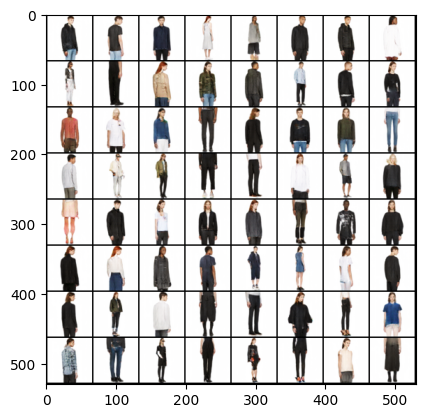

In [18]:
num_images = 64
clean_noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(clean_noise)

# let's plot these images using torchvision and matplotlib

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

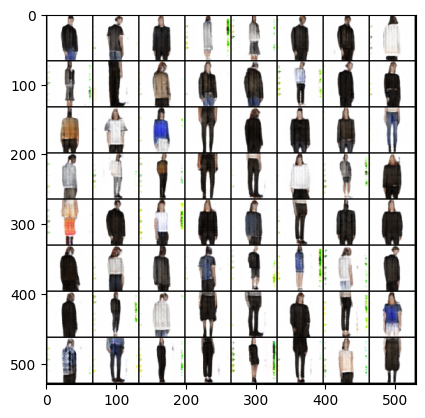

In [19]:
num_images = 64
with torch.no_grad():
    generated_images = model_compressed.test(clean_noise)

# let's plot these images using torchvision and matplotlib

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

## TRAIN

In [20]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 120
num_samples = 10000
batch_size = 64

# Generate random noise as inputs
def generate_random_noise(batch_size, latent_dim):
    return torch.randn(batch_size, latent_dim, 1, 1).to(device)


In [21]:
# Load the original model (teacher)
teacher = model
teacher.netG.eval()

# Load your modified model (student)
student = model_compressed  # Replace with your modified model definition
student.netG.train()

DataParallel(
  (module): GNet(
    (formatLayer): Sequential(
      (0): ConvTranspose2d(120, 30, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): ConvTranspose2d(30, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (2): ConvTranspose2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (main): Sequential(
      (batchNorm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (convTranspose1): Sequential(
        (0): ConvTranspose2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (2): ConvTranspose2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (batchNorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (convTranspose2): Sequential(
        (0): ConvTranspose2d(256, 6

In [22]:
loss_fn = nn.MSELoss()  # Loss function to match the outputs

optimizer = torch.optim.Adam(student.netG.parameters())

In [23]:
epochs = 20

for epoch in range(epochs):
    for _ in tqdm.tqdm(range(num_samples // batch_size)):
        # Generate random noise
        noise = generate_random_noise(batch_size, latent_dim)

        # Get teacher outputs
        with torch.no_grad():  # No gradients needed for the teacher
            teacher_outputs = teacher.netG(noise)

        # Get student outputs
        student_outputs = student.netG(noise)

        # Compute loss
        loss = loss_fn(student_outputs, teacher_outputs)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


100%|██████████| 156/156 [00:00<00:00, 175.79it/s]


Epoch [1/20], Loss: 0.0469


100%|██████████| 156/156 [00:00<00:00, 207.63it/s]


Epoch [2/20], Loss: 0.0419


100%|██████████| 156/156 [00:00<00:00, 208.65it/s]


Epoch [3/20], Loss: 0.0397


100%|██████████| 156/156 [00:00<00:00, 207.11it/s]


Epoch [4/20], Loss: 0.0426


100%|██████████| 156/156 [00:00<00:00, 207.57it/s]


Epoch [5/20], Loss: 0.0419


100%|██████████| 156/156 [00:00<00:00, 207.13it/s]


Epoch [6/20], Loss: 0.0369


100%|██████████| 156/156 [00:00<00:00, 207.00it/s]


Epoch [7/20], Loss: 0.0426


100%|██████████| 156/156 [00:00<00:00, 206.99it/s]


Epoch [8/20], Loss: 0.0353


100%|██████████| 156/156 [00:00<00:00, 206.50it/s]


Epoch [9/20], Loss: 0.0417


100%|██████████| 156/156 [00:00<00:00, 207.85it/s]


Epoch [10/20], Loss: 0.0395


100%|██████████| 156/156 [00:00<00:00, 206.42it/s]


Epoch [11/20], Loss: 0.0381


100%|██████████| 156/156 [00:00<00:00, 205.84it/s]


Epoch [12/20], Loss: 0.0381


100%|██████████| 156/156 [00:00<00:00, 207.49it/s]


Epoch [13/20], Loss: 0.0369


100%|██████████| 156/156 [00:00<00:00, 205.77it/s]


Epoch [14/20], Loss: 0.0362


100%|██████████| 156/156 [00:00<00:00, 205.07it/s]


Epoch [15/20], Loss: 0.0345


100%|██████████| 156/156 [00:00<00:00, 208.29it/s]


Epoch [16/20], Loss: 0.0344


100%|██████████| 156/156 [00:00<00:00, 206.24it/s]


Epoch [17/20], Loss: 0.0365


100%|██████████| 156/156 [00:00<00:00, 208.85it/s]


Epoch [18/20], Loss: 0.0324


100%|██████████| 156/156 [00:00<00:00, 208.63it/s]


Epoch [19/20], Loss: 0.0365


100%|██████████| 156/156 [00:00<00:00, 206.84it/s]

Epoch [20/20], Loss: 0.0349


##### Photo 2

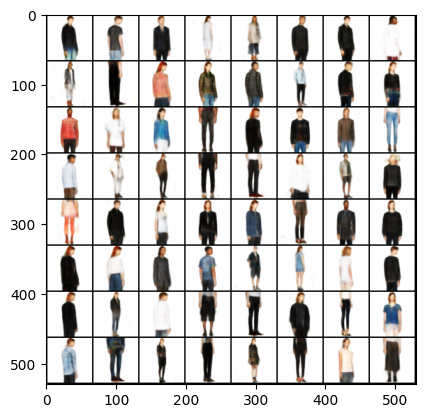

In [24]:
model_compressed = student
num_images = 64
with torch.no_grad():
    generated_images = model_compressed.test(clean_noise)

# let's plot these images using torchvision and matplotlib

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

# Replace

In [25]:
## Convert RESNET
def replace_model(resnet):
    layer_norms = {}
    for name, module in resnet.named_modules():
        if isinstance(module, torch.nn.ConvTranspose2d):
            parent_name = ".".join(name.split(".")[:-1])
            attr_name = name.split(".")[-1]
            print(parent_name, end=": ")
            # Access the parent module
            parent_module = resnet
            if parent_name:
                parent_module = dict(resnet.named_modules())[parent_name]

            # Replace the old layer with the new one
            weights = module.weight.size()
            if weights[1] == 3:
                continue
            result = nn.Sequential(nn.ConvTranspose2d(weights[0], weights[0] // 2, kernel_size=1, bias=False),
                                   nn.ConvTranspose2d(weights[0] // 2, weights[1] // 2, kernel_size=(weights[2], weights[3]), stride=module.stride, padding=module.padding, bias=False),
                                   nn.ConvTranspose2d(weights[1] // 2, weights[1], kernel_size=1, bias=False))
            setattr(parent_module, attr_name, result)
            del result
            gc.collect()
            torch.cuda.empty_cache()
    return resnet

In [26]:
model_replaced_G = replace_model(model_replaced.getNetG())

: main: main: main: main: 

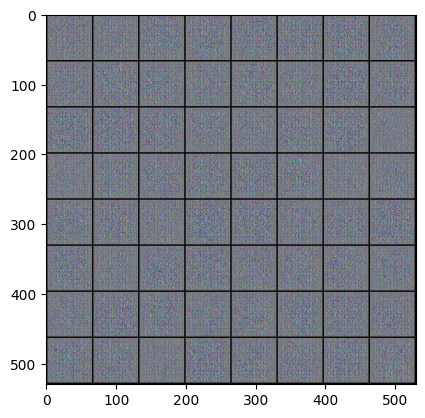

In [27]:
model_replaced.netG = nn.DataParallel(model_replaced_G)
num_images = 64
with torch.no_grad():
    generated_images = model_replaced.test(clean_noise)

# let's plot these images using torchvision and matplotlib

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

## TRAIN

In [28]:
latent_dim = 120
num_samples = 10000
batch_size = 64


# Generate random noise as inputs
def generate_random_noise(batch_size, latent_dim):
    return torch.randn(batch_size, latent_dim, 1, 1).to(device)

In [29]:
# Load the original model (teacher)
teacher = model
teacher.netG.eval()

# Load your modified model (student)
student = model_replaced  # Replace with your modified model definition
student.netG.train()

DataParallel(
  (module): GNet(
    (formatLayer): Sequential(
      (0): ConvTranspose2d(120, 60, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): ConvTranspose2d(60, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (2): ConvTranspose2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (main): Sequential(
      (batchNorm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (convTranspose1): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (2): ConvTranspose2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (batchNorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (convTranspose2): Sequential(
        (0): ConvTranspose2d(256,

In [30]:
loss_fn = nn.MSELoss()  # Loss function to match the outputs

optimizer = torch.optim.Adam(student.netG.parameters())

In [31]:
for epoch in range(epochs):
    for _ in tqdm.tqdm(range(num_samples // batch_size)):
        # Generate random noise
        noise = generate_random_noise(batch_size, latent_dim)

        # Get teacher outputs
        with torch.no_grad():  # No gradients needed for the teacher
            teacher_outputs = teacher.netG(noise)

        # Get student outputs
        student_outputs = student.netG(noise)

        # Compute loss
        loss = loss_fn(student_outputs, teacher_outputs)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

100%|██████████| 156/156 [00:01<00:00, 130.28it/s]


Epoch [1/20], Loss: 0.1317


100%|██████████| 156/156 [00:01<00:00, 133.02it/s]


Epoch [2/20], Loss: 0.0972


100%|██████████| 156/156 [00:01<00:00, 133.75it/s]


Epoch [3/20], Loss: 0.0744


100%|██████████| 156/156 [00:01<00:00, 133.42it/s]


Epoch [4/20], Loss: 0.0658


100%|██████████| 156/156 [00:01<00:00, 133.11it/s]


Epoch [5/20], Loss: 0.0711


100%|██████████| 156/156 [00:01<00:00, 132.05it/s]


Epoch [6/20], Loss: 0.0522


100%|██████████| 156/156 [00:01<00:00, 132.91it/s]


Epoch [7/20], Loss: 0.0555


100%|██████████| 156/156 [00:01<00:00, 132.07it/s]


Epoch [8/20], Loss: 0.0526


100%|██████████| 156/156 [00:01<00:00, 131.89it/s]


Epoch [9/20], Loss: 0.0460


100%|██████████| 156/156 [00:01<00:00, 131.13it/s]


Epoch [10/20], Loss: 0.0476


100%|██████████| 156/156 [00:01<00:00, 132.05it/s]


Epoch [11/20], Loss: 0.0489


100%|██████████| 156/156 [00:01<00:00, 132.69it/s]


Epoch [12/20], Loss: 0.0413


100%|██████████| 156/156 [00:01<00:00, 133.42it/s]


Epoch [13/20], Loss: 0.0427


100%|██████████| 156/156 [00:01<00:00, 132.65it/s]


Epoch [14/20], Loss: 0.0395


100%|██████████| 156/156 [00:01<00:00, 132.96it/s]


Epoch [15/20], Loss: 0.0414


100%|██████████| 156/156 [00:01<00:00, 133.15it/s]


Epoch [16/20], Loss: 0.0387


100%|██████████| 156/156 [00:01<00:00, 132.85it/s]


Epoch [17/20], Loss: 0.0361


100%|██████████| 156/156 [00:01<00:00, 132.83it/s]


Epoch [18/20], Loss: 0.0378


100%|██████████| 156/156 [00:01<00:00, 131.81it/s]


Epoch [19/20], Loss: 0.0376


100%|██████████| 156/156 [00:01<00:00, 133.13it/s]

Epoch [20/20], Loss: 0.0412


##### Photo 3

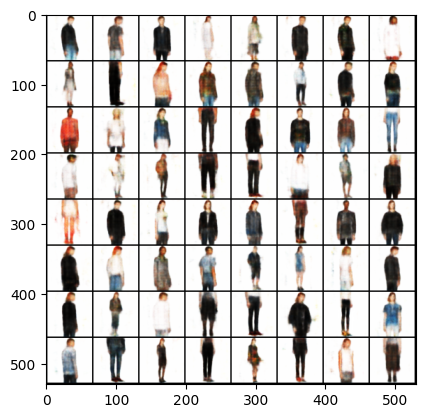

In [32]:
model_replaced = student
num_images = 64
with torch.no_grad():
    generated_images = model_replaced.test(clean_noise)

# let's plot these images using torchvision and matplotlib

grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

In [33]:
model_replaced.netG

DataParallel(
  (module): GNet(
    (formatLayer): Sequential(
      (0): ConvTranspose2d(120, 60, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): ConvTranspose2d(60, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (2): ConvTranspose2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (main): Sequential(
      (batchNorm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (convTranspose1): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (2): ConvTranspose2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (batchNorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (convTranspose2): Sequential(
        (0): ConvTranspose2d(256,

In [34]:
# %%timeit -r 10 -n 1000
# model_compressed.netG(clean_noise)

In [35]:
# %%timeit -r 10 -n 1000
# model.netG(clean_noise)

# TEST

## Random Tensor

In [36]:
random_tensor = torch.randn(100, 50, 25, 10).to(device)

## Decomposition

In [37]:
core, factors = tucker(random_tensor, rank=[100, 50, 25, 10])

In [38]:
factors[0].size()

torch.Size([100, 100])

## Manual Restore

In [39]:
factor1 = torch.tensordot(core, factors[0], dims=([0], [1]))
print(factor1.shape)
factor2 = torch.tensordot(factor1, factors[1], dims=([0], [1]))
print(factor2.shape)
factor3 = torch.tensordot(factor2, factors[2], dims=([0], [1]))
print(factor3.shape)
factor4 = torch.tensordot(factor3, factors[3], dims=([0], [1]))
print(factor4.shape)

torch.Size([50, 25, 10, 100])
torch.Size([25, 10, 100, 50])
torch.Size([10, 100, 50, 25])
torch.Size([100, 50, 25, 10])


## Compare manual restore vs built-it restore

In [40]:
print(tl.norm(random_tensor - factor4) / tl.norm(random_tensor))
print(tl.norm(random_tensor - tl.tucker_to_tensor((core, factors))) / tl.norm(random_tensor))
print(torch.sum(factor4 - tl.tucker_to_tensor((core, factors))))

tensor(3.3906e-05, device='cuda:0')
tensor(3.3906e-05, device='cuda:0')
tensor(0., device='cuda:0')


## Test small conv

In [41]:
def replace_deconv_layers(module):
    for name, child in module.named_children():
        # If child is a ConvTranspose2d, replace it with a new layer
        if isinstance(child, nn.ConvTranspose2d):
            weight = child.weight.size()
            if weight[1] == 3:
                continue
            TKD, _ = TKD_conv(child, [weight[0] // 4, weight[1] // 4, weight[2] * weight[3]])
            setattr(module, name, TKD)
        else:
            # Recursively process nested submodules (for custom blocks)
            replace_deconv_layers(child)

model_compressed = deepcopy(model.netG)
replace_deconv_layers(model_compressed)

TKD (120, 512, (4, 4)): 0.5199814438819885
TKD (512, 256, (4, 4)): 0.7864285707473755
TKD (256, 128, (4, 4)): 0.7992614507675171
TKD (128, 64, (4, 4)): 0.7197096347808838


In [42]:
tensor = torch.randn(64, 120, 1, 1).to(device)
tensor_decomposed = deepcopy(tensor)

In [43]:
tensor = model.netG(tensor)
tensor_decomposed = model_compressed(tensor_decomposed)

In [44]:
model.netG

DataParallel(
  (module): GNet(
    (formatLayer): ConvTranspose2d(120, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (main): Sequential(
      (batchNorm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (convTranspose1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (batchNorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (convTranspose2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (convTranspose3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (batchNorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (re

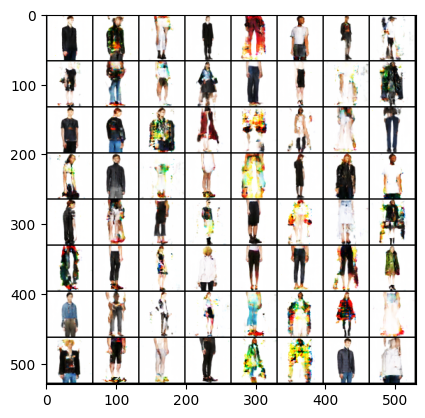

In [45]:
grid = torchvision.utils.make_grid(tensor.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

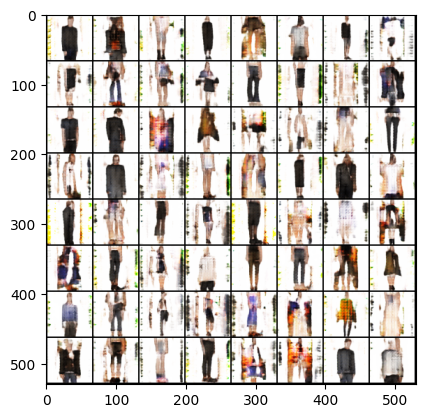

In [46]:
grid = torchvision.utils.make_grid(tensor_decomposed.clamp(min=-1, max=1), scale_each=False, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

In [47]:
torch.mean(tensor - tensor_decomposed)

tensor(0.0918, device='cuda:0', grad_fn=<MeanBackward0>)